https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [16]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [9]:
# load dataset
# series = read_csv('..\data\GlobalTemperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv('..\data\GlobalTemperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [20]:
# create a dataframe for Annualized Average Temperature
series = series.LandAverageTemperature.resample('A').mean()

In [21]:
series.head()

dt
1750-12-31    8.719364
1751-12-31    7.976143
1752-12-31    5.779833
1753-12-31    8.388083
1754-12-31    8.469333
Freq: A-DEC, Name: LandAverageTemperature, dtype: float64

In [22]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [23]:
diff_values.head()

0   -0.743221
1   -2.196310
2    2.608250
3    0.081250
4   -0.113750
dtype: float64

In [24]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [27]:
supervised_values

array([[ 0.        , -0.74322078],
       [-0.74322078, -2.19630952],
       [-2.19630952,  2.60825   ],
       [ 2.60825   ,  0.08125   ],
       [ 0.08125   , -0.11375   ],
       [-0.11375   ,  0.494     ],
       [ 0.494     ,  0.17241667],
       [ 0.17241667, -2.27841667],
       [-2.27841667,  1.2415    ],
       [ 1.2415    , -0.79991667],
       [-0.79991667,  1.58733333],
       [ 1.58733333, -0.166     ],
       [-0.166     , -1.10975   ],
       [-1.10975   ,  0.90358333],
       [ 0.90358333, -0.14841667],
       [-0.14841667,  0.15375   ],
       [ 0.15375   , -0.18416667],
       [-0.18416667, -1.44016667],
       [-1.44016667,  0.91325   ],
       [ 0.91325   , -0.00266667],
       [-0.00266667,  0.16125   ],
       [ 0.16125   ,  0.34033333],
       [ 0.34033333,  0.028     ],
       [ 0.028     ,  0.55066667],
       [ 0.55066667,  0.41091667],
       [ 0.41091667, -0.87908333],
       [-0.87908333, -0.04775   ],
       [-0.04775   ,  0.286     ],
       [ 0.286     ,

In [28]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [32]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [38]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1000, 4)

In [39]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.40171093],
       [-0.3209526 ],
       [ 0.70373815],
       [-0.12052327],
       [-0.10613424],
       [-0.16205257],
       [-0.28882295],
       [-0.28539371],
       [ 0.63305336],
       [ 0.01374549],
       [ 0.05667204],
       [-0.32521558],
       [-0.1526702 ],
       [ 0.33815342],
       [-0.08523613],
       [-0.21708697],
       [-0.30674314],
       [-0.36898276],
       [ 0.05036664],
       [ 0.02182484],
       [-0.04774857],
       [-0.05376601],
       [-0.0672608 ],
       [-0.05730331],
       [-0.07856941],
       [-0.07842493],
       [-0.01877284],
       [-0.03951126],
       [-0.06107932],
       [-0.07465297],
       [-0.07934088],
       [ 0.0016132 ],
       [-0.02151936],
       [-0.03362638],
       [-0.05450106],
       [-0.0292508 ],
       [-0.07928741],
       [-0.05112737],
       [-0.07084143],
       [-0.0524928 ],
       [-0.03572124],
       [-0.05860245],
       [-0.04702061],
       [-0.05679262],
       [-0.06719488],
       [-0

In [40]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=9.559424, Expected=9.324583
Month=2, Predicted=9.383309, Expected=9.700917
Month=3, Predicted=9.701504, Expected=9.532500
Month=4, Predicted=9.577074, Expected=9.732167
Month=5, Predicted=9.748120, Expected=9.431750
Month=6, Predicted=9.496392, Expected=9.505250
Month=7, Predicted=9.542703, Expected=9.703083
Month=8, Predicted=9.718096, Expected=9.516000
Month=9, Predicted=9.567956, Expected=9.507333
Month=10, Predicted=9.550493, Expected=9.606500
Month=11, Predicted=9.634856, Expected=9.570667
Month=12, Predicted=9.609871, Expected=9.831000


In [41]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.190


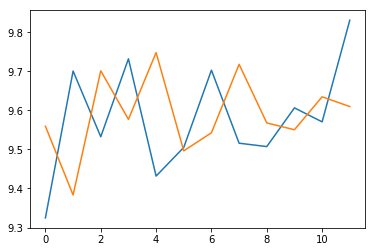

In [42]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()